In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())



id_to_fn = {
'1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
'1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
'1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz' }


# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing



In [ ]:
#Some Global Variables 
#MAKE SURE TO RUN THIS
patch_size = 16
patches = 8
image_size_w = image_size_h = 128

In [ ]:
import numpy as np

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  img = np.load(image_path)
  labels = np.load(labels_path, allow_pickle=True, encoding="latin1")

  img_data    = img["arr_0"]
  labels_data = labels["arr_0"] 

  train_data = int(0.8*len(img_data))

  train_images     = img_data[:train_data,:,:,:]
  train_raw_labels = labels_data[:train_data]

  test_images     = img_data[train_data:, :, :, :]
  test_raw_labels = labels_data[train_data:]

  return train_images, train_raw_labels, test_images, test_raw_labels

def create_y_label(image, raw_label):
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  y_label = np.zeros((8,8,8))
  
  patch_size = 16
  patches = 8
  
  for l in label:
    x1,y1,x2,y2 = l[1:]

    center_x    = (x1+x2)/2
    center_y    = (y1+y2)/2

    grid_coordinate_x = int(center_x/patch_size) 
    grid_coordinate_y = int(center_y/patch_size)

    grid_offset_x = (center_x%patch_size)/patch_size
    grid_offset_y = (center_y%patch_size)/patch_size

    width  = (x2-x1)/128
    height = (y2-y1)/128

    class_probabilites = np.zeros(3)

    #l[0] had object class
    class_probabilites[int(l[0])] = 1

    y_label[0, grid_coordinate_x, grid_coordinate_y] = 1
    y_label[1:5, grid_coordinate_x, grid_coordinate_y] = [grid_offset_x,
                                                          grid_offset_y,
                                                          width,
                                                          height]

    y_label[5:, grid_coordinate_x, grid_coordinate_y] = class_probabilites

  return y_label




In [ ]:
#####SET YOU OWN PATH HERE####
data = np.load("/content/drive/My Drive/CIS680_2019/HW2/test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)
print(raw_label.shape)
## fill in your code to compute the your processed y_label
y_label = np.zeros((5,8,8,8))

for i, label in enumerate(raw_label):
  y_label[i] = create_y_label(img[i], label)

#print("Predicted: ", y_label[0][4,:,:])
#print("True: ", true_y_label[0][4,:,:])
# test you processed labels
for i in range(len(img)):
  
  comparison = y_label[i] == true_y_label[i]
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


(5,)
Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


torch.float32
torch.float32


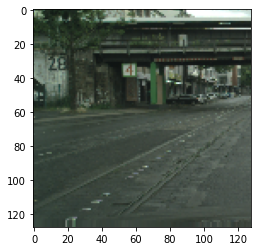

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
class ToTensor(object):
    """Convert ndarrays in sample to Tensors, with Transpose"""

    def __call__(self, sample):
        image, label = sample
        image = image.transpose((2, 0, 1))
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.float)

class Dataset(torch.utils.data.Dataset):
  def __init__(self,np_data, transform=None):
    self.img_data, self.label_data = np_data
    self.transform = transform
  
  def __getitem__(self, index):
    img   = self.img_data[index,:,:,:]
    label = self.label_data[index]
    if(len(self.transform)):
        t1 = self.transform[0]
        img, label = t1((img,label))

        #t2 = self.transform[1]
        #img = t2(img)
        #img, label = self.transform((img,label))

    return img, label
  
  def __len__(self):
    return self.img_data.shape[0]


image_path  = "/content/images.npz"
labels_path = "/content/labels.npz"

train_images, train_raw_labels, test_images, test_raw_labels = loadData(image_path, labels_path)

'''
print(train_images.shape)
print(train_raw_labels.shape)
print(test_images.shape)
print(test_raw_labels.shape)
print(test_raw_labels.shape[0])
print(test_labels.shape)
'''

train_labels = np.zeros((train_raw_labels.shape[0],8,8,8))
test_labels  = np.zeros((test_raw_labels.shape[0],8,8,8))

for i, label in enumerate(train_raw_labels):
  train_labels[i] = create_y_label(train_images[i], label)

for i, label in enumerate(test_raw_labels):
  test_labels[i] = create_y_label(test_images[i], label)


transform = [ToTensor()]#, torchvision.transforms.Normalize(0.5,0.5)]
TrainDataset = Dataset([train_images, train_labels],transform)
TestDataset =  Dataset([test_images,  test_labels],transform)

img, label = TrainDataset[0]
print(img.dtype)
print(label.dtype)
plt.imshow(np.uint8(img.numpy().transpose((1,2,0))))
plt.show()


Set up the data set for training and testing.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  if sys.path[0] == '':


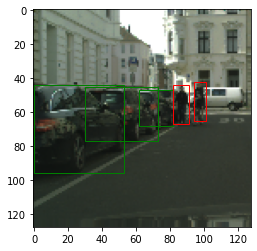

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(image, nw_output, name="output"):
  image_size_w=image_size_h=128
  grid_size = 16
  thresh = 0
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.imshow(np.uint8(image.numpy().transpose((1,2,0))))
  idx = torch.gt(nw_output[0,:,:],thresh)
  grid = torch.nonzero(idx)
  boxes = nw_output[:, idx]

  for i in range(boxes.shape[1]):
    width    = boxes[3,i] * image_size_w
    height   = boxes[4,i] * image_size_h
    center_x = boxes[1,i] * grid_size + (grid[i, 0] * grid_size)
    center_y = boxes[2,i] * grid_size + (grid[i, 1] * grid_size)
    if(torch.gt(boxes[5,i],thresh) and torch.gt(boxes[5,i],boxes[6,i]) and torch.gt(boxes[5,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='r',facecolor='none')
      #ax.text(center_x-width/2,center_y-height/2, "pedestrian",fontsize=15)
      ax.add_patch(rect)
    
    if(torch.gt(boxes[6,i],thresh) and torch.gt(boxes[6,i],boxes[5,i]) and torch.gt(boxes[6,i],boxes[7,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='b',facecolor='none')
      #ax.text(center_x-width/2,center_y-height/2, "traffic light",fontsize=15)
      ax.add_patch(rect)

    if(torch.gt(boxes[7,i],thresh) and torch.gt(boxes[7,i],boxes[6,i]) and torch.gt(boxes[7,i],boxes[5,i])):
      rect = patches.Rectangle((center_x-width/2,center_y-height/2),width,height,linewidth=1,edgecolor='g',facecolor='none')
      #ax.text(center_x-width/2,center_y-height/2, "car",fontsize=15)
      ax.add_patch(rect)

  plt.savefig(name + ".png")

img, label = TrainDataset[6]
visualize(img, label)


8


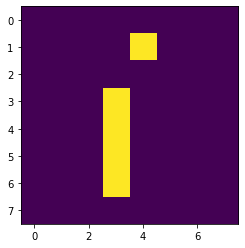

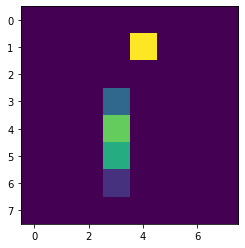

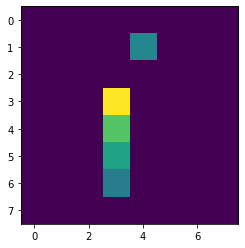

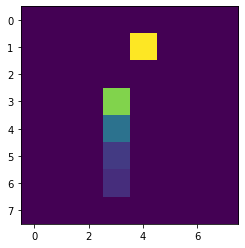

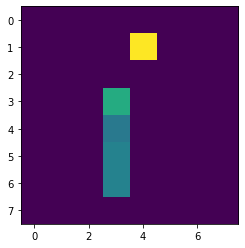

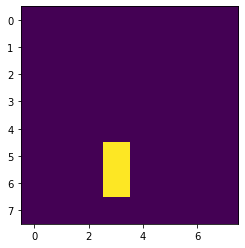

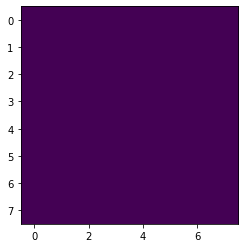

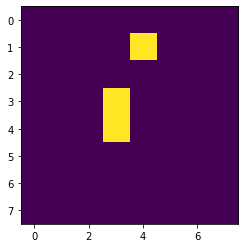

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_channels(nw_output):
  print(nw_output.shape[0])
  for i in range(nw_output.shape[0]):
      fig = plt.figure()
      ax  = fig.add_subplot(111)
      plt.imshow(nw_output[i,:,:])
      plt.savefig("channel_"+str(i)+".png")

img, label = TrainDataset[6]
visualize_channels(label)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

## use the processed labels and use the correct image dimensions for the pytorch loader.
## images = images.transpose(0,3,1,2)

BATCH_SIZE = 64
batch_size =64
train_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TrainDataset,batch_size=batch_size, shuffle=True)


# Model Definition

In [ ]:
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.relu = torch.nn.ReLU(inplace=False)
    
    self.conv1 = torch.nn.Conv2d(3,32,kernel_size=4,padding=1, stride=2)
    self.batch_norm1 = torch.nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv2 = torch.nn.Conv2d(32,64,kernel_size=4,padding=1, stride=2)
    self.batch_norm2 = torch.nn.BatchNorm2d(64,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv3 = torch.nn.Conv2d(64,128,kernel_size=4,padding=1, stride=2)
    self.batch_norm3 = torch.nn.BatchNorm2d(128,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=4,padding=1, stride=2)
    self.batch_norm4 = torch.nn.BatchNorm2d(256,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv5 = torch.nn.Conv2d(256,512,kernel_size=4,padding=1, stride=2)
    self.batch_norm5 = torch.nn.BatchNorm2d(512,eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv6 = torch.nn.Conv2d(512,1024, kernel_size=4,padding=1, stride=2)
    self.batch_norm6 = torch.nn.BatchNorm2d(1024, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv7 = torch.nn.ConvTranspose2d(1024, 256, kernel_size=4,padding=1, stride=2)
    self.batch_norm7 = torch.nn.BatchNorm2d(256, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)
    
    self.conv8 = torch.nn.ConvTranspose2d(256, 64, kernel_size=4,padding=1, stride=2)
    self.batch_norm8 = torch.nn.BatchNorm2d(64, eps=1e-05,momentum=0.1,
                                            affine=True,track_running_stats=True)

    self.conv9 = torch.nn.Conv2d(64, 8, kernel_size=3, padding=1, stride=1)


  def forward(self, X):
      layer1 = self.relu(self.batch_norm1(self.conv1(X)))
      layer2 = self.relu(self.batch_norm2(self.conv2(layer1)))
      layer3 = self.relu(self.batch_norm3(self.conv3(layer2)))
      layer4 = self.relu(self.batch_norm4(self.conv4(layer3)))
      layer5 = self.relu(self.batch_norm5(self.conv5(layer4)))
      layer6 = self.relu(self.batch_norm6(self.conv6(layer5)))
      layer7 = self.relu(self.batch_norm7(self.conv7(layer6)))
      layer8 = self.relu(self.batch_norm8(self.conv8(layer7)))
      out = torch.sigmoid(self.conv9(layer8))
      return out      

In [ ]:
from sklearn import metrics
def IOU(prediction, grnd_truth, object_idx, debug):
  #Extracting centers and h w
  cpx = prediction[:,0]
  cpy = prediction[:,1]
  wp = prediction[:,2]
  hp = prediction[:,3]
  
  
  cgx = grnd_truth[:,0]
  cgy = grnd_truth[:,1]
  wg = grnd_truth[:,2]
  hg = grnd_truth[:,3]
  
  #Rescaling width and height
  wp= wp * image_size_w
  hp= hp * image_size_h
  wg= wg * image_size_w
  hg= hg * image_size_h

  #Rescaling center
  cpx = cpx * patch_size + object_idx[:,0] * patch_size
  cpy = cpy * patch_size + object_idx[:,1] * patch_size
  cgx = cgx * patch_size + object_idx[:,0] * patch_size
  cgy = cgy * patch_size + object_idx[:,1] * patch_size

  #Box format [x1 y1 x2 y2]
  box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
  box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

  xA = torch.max(box1[0], box2[0])
  yA = torch.max(box1[1], box2[1])

  xB = torch.min(box1[2], box2[2])
  yB = torch.min(box1[3], box2[3])

  area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device="cuda:0")) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device="cuda:0"))

  area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

  iou = torch.div(area_intersection+1,area_union+1)
  
  if debug:
    print("cgx: ", cpx.shape)
    print("wg: ", wp.shape)
    print("object_idx: ", object_idx.shape)
    print("cpx: ", cpx.shape)
    print("wp: ", wp.shape)
    print("xA: ",xA)
    print("xB: ",xB)
    print("yA: ",yA)
    print("yB: ",yB)
    print("xB-xA: ", xB-xA)
    print("yB-yA: ", yB-yA)
    print(iou.shape)
    print("Intersection Over Union: ",iou)
    print("Intersection: ",area_intersection)
    print("Union: ", area_union)
    print("Intersection Over Union: ",iou)
  
  return iou

def YoloLoss(output, target, lambda_coord, lambda_noobj, debug=False):
  #n*8*8*8
  object_idx  = target[:,0,:,:].nonzero()
  nobject_idx = (target[:,0,:,:]==0).nonzero()

  target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
  predicted_object = output[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]


  predicted_nobject = output[nobject_idx[:,0],:,nobject_idx[:,1],nobject_idx[:,2]]

  localization_loss = torch.sum((target_object[:,1]-predicted_object[:,1])**2 + 
                                (target_object[:,2]-predicted_object[:,2])**2)
  
  bbox_loss         = torch.sum((torch.sqrt(target_object[:,3])-torch.sqrt(predicted_object[:,3]))**2 + 
                                (torch.sqrt(target_object[:,4])-torch.sqrt(predicted_object[:,4]))**2)
  
  iou = IOU(predicted_object[:, 1:5], 
            target_object[:, 1:5], object_idx, debug)
  
  #obj_confidence_loss = torch.sum((iou - predicted_object[:,0])**2)
  obj_confidence_loss = torch.sum((1 - predicted_object[:,0])**2)  
  nobj_confidence_loss= torch.sum((0 - predicted_nobject[:, 0])**2)

  pc_loss = torch.sum((target_object[:,5:]-predicted_object[:,5:])**2)

  loss = lambda_coord*(localization_loss + bbox_loss) + obj_confidence_loss + lambda_noobj*nobj_confidence_loss + pc_loss 
  
  if debug:
    print("localization loss: ", localization_loss)
    print("Bbox loss: ", bbox_loss)
    #print(torch.sqrt(target_object[:,3])-torch.sqrt(predicted_object[:,3]))
    #print(torch.sqrt(target_object[:,4])-torch.sqrt(predicted_object[:,4]))
    #print("Target w:", predicted_object[:,4])
    #print("Target h:", predicted_object[:,3])
    
    print("Confidence loss: ", obj_confidence_loss)
    print("Non object loss: ", nobj_confidence_loss)
    print("PC Loss: ", pc_loss)
    print("Loss: ", loss)
  
  return loss, localization_loss, bbox_loss, pc_loss, obj_confidence_loss, nobj_confidence_loss

def bbox(grid_coords, prediction):
  #Extracting centers and h w
  cpx = prediction[1,grid_coords[:,0],grid_coords[:,1]]
  cpy = prediction[2,grid_coords[:,0],grid_coords[:,1]]
  wp =  prediction[3,grid_coords[:,0],grid_coords[:,1]]
  hp =  prediction[4,grid_coords[:,0],grid_coords[:,1]]

  #Rescaling width and height
  wp= wp * image_size_w
  hp= hp * image_size_h

  #Rescaling center
  cpx = cpx * patch_size + grid_coords[:,0] * patch_size
  cpy = cpy * patch_size + grid_coords[:,1] * patch_size

  #Stack in torch
  box1 =  torch.stack(cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2, dim=1)

def iou_nms(coord1, coord2, nms_output):
  #Extracting centers and h w
  cpx = nms_output[1,coord1[0],coord1[1]]
  cpy = nms_output[2,coord1[0],coord1[1]]
  wp  = nms_output[3,coord1[0],coord1[1]]
  hp  = nms_output[4,coord1[0],coord1[1]]
  
  
  cgx = nms_output[1,coord2[0],coord2[1]]
  cgy = nms_output[2,coord2[0],coord2[1]]
  wg  = nms_output[3,coord2[0],coord2[1]] 
  hg  = nms_output[4,coord2[0],coord2[1]]
  
  #Rescaling width and height
  wp= wp * image_size_w
  hp= hp * image_size_h
  wg= wg * image_size_w
  hg= hg * image_size_h

  #Rescaling center
  cpx = cpx * patch_size + coord1[0] * patch_size
  cpy = cpy * patch_size + coord1[1] * patch_size
  cgx = cgx * patch_size + coord2[0] * patch_size
  cgy = cgy * patch_size + coord2[1] * patch_size

  #Box format [x1 y1 x2 y2]
  box1 =  [cpx-wp/2, cpy-hp/2, cpx+wp/2, cpy+hp/2]
  box2 =  [cgx-wg/2, cgy-hg/2, cgx+wg/2, cgy+hg/2]

  xA = torch.max(box1[0], box2[0])
  yA = torch.max(box1[1], box2[1])

  xB = torch.min(box1[2], box2[2])
  yB = torch.min(box1[3], box2[3])

  area_intersection = torch.max(xB-xA, torch.zeros(xB.shape, dtype=xB.dtype, device="cuda:0")) * torch.max(yB-yA, torch.zeros(yB.shape, dtype=yB.dtype, device="cuda:0"))

  area_union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - area_intersection

  iou = torch.div(area_intersection+1,area_union+1)
  return iou

def NMS(nw_output):

  #network output (n,8,8,8)
  nms_threshold = 0.3
  below_threshold = torch.le(nw_output[:,0,:,:],0.6).nonzero()
  nms_output = torch.clone(nw_output)
  nms_output[below_threshold[:,0], 0, below_threshold[:,1], below_threshold[:,2]] = 0
  nms_output1 = torch.clone(nms_output)
  classes = 3
  #print(below_threshold.shape)
  for i in range(nms_output.shape[0]):
    for c in range(classes):
      grid_coords = torch.logical_and(torch.max(nms_output[i,5:8,:,:],dim=0)[1] == c , nms_output[i,0,:,:]>nms_threshold).nonzero() 
      #confidence_scores = nms_output[i,0,grid_coors[:,0],grid_coors[:,1]] * nms_output[i,(5+c),grid_coors[:,0],grid_coors[:,1]]  
      for coord1 in grid_coords:
        confidence_score_c1 = nms_output[i,0,coord1[0],coord1[1]] * nms_output[i,5+c,coord1[0],coord1[1]]
        for coord2 in grid_coords:
          confidence_score_c2 = nms_output[i,0,coord2[0],coord2[1]] * nms_output[i,5+c,coord2[0],coord2[1]]
          if(iou_nms(coord1, coord2, nms_output[i,:,:,:])>0.5 and confidence_score_c1<confidence_score_c2):
            #Supress
            nms_output[i,0,coord1[0],coord1[1]] = 0

  return nms_output, nms_output1



def average_precision(matches, scores, trues):
  ## please fill in the appropriate arguements 
  ## compute the average precision as mentioned in the PDF.
  ## it might be helpful to use - from sklearn.metrics import auc to compute area under the curve.

  matches = np.asarray(matches)
  scores = np.asarray(scores)
  max = np.max(scores)

  ln  = np.linspace(0.6, max, 100)
  recall_mat = np.zeros((101))
  precision_mat = np.zeros((101))

  for i, th in enumerate(ln):
    TP = np.sum(matches[scores>th])
    P  = matches[scores>th].shape[0]
    precision = 1
    if P>0:
      precision = TP/P

    recall =1
    if trues>0:
      recall = TP/trues
    precision_mat[i] = precision
    recall_mat[i] = recall

  recall_mat[100]    = 0
  precision_mat[100] = 1

  sorted_ind       = np.argsort(recall_mat)
  sorted_recall    = recall_mat[sorted_ind]
  sorted_precision = precision_mat[sorted_ind]
  area = metrics.auc(sorted_recall, sorted_precision)
  
  return area, recall_mat, precision_mat

  

def AP_test(test_loader):
    AP=0
    cnt =0
    matches= {0:[],1:[],2:[]}
    scores = {0:[],1:[],2:[]}
    trues  = {0:0,1:0,2:0}
    classes =3
    for data in test_loader:

      test, label = data
      test = test.to(device)
      label = label.to(device)
      net_out = yolo_net(test)
      nms_out, nms_out1 = NMS(net_out)      
      m, s, t = yolo_evaluation(nms_out, label)
      #print(m)
      #print(s)
      #print(t)
      for c in range(classes): 
        if(len(m[c])>0):
          matches[c].extend(m[c])
        if(len(s[c])>0):
          scores[c].extend(s[c])
        trues[c]  = trues[c]+t[c]

    for c in range(classes):
      #print(matches[c].shape)
      if (len(matches[c])>0):
        #print(len(matches[c]))
        #print(len(scores[c]))
        #print(trues[c])

        area, recall_mat, precision_mat = average_precision(matches[c],scores[c],trues[c])
        AP  += area
        #print(AP)
        cnt+=1;
    if cnt>0:
      map=AP/cnt

    return map

Epoch 1/40
tensor(439.7659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 2/40
tensor(311.4697, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 3/40
tensor(279.8253, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 4/40
tensor(278.3751, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 5/40
tensor(231.3150, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 6/40
tensor(219.6552, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 7/40
tensor(182.7466, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 8/40
tensor(161.8516, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 9/40
tensor(150.9533, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 10/40
tensor(137.5319, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 11/40
tensor(87.6190, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 12/40
tensor(72.0328, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 13/40
tensor(44.6165, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 14/40
tensor(53.6983, device='cuda:0', grad_fn=<AddBackward0>)
Epoch 15/40
tensor(35.5185, devic

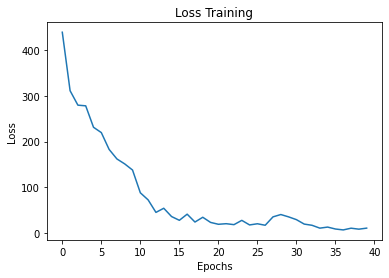

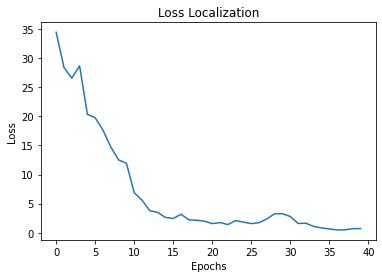

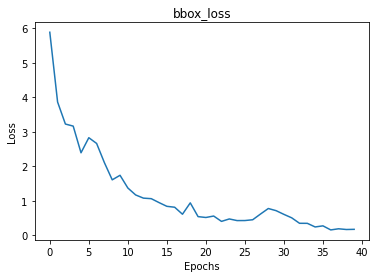

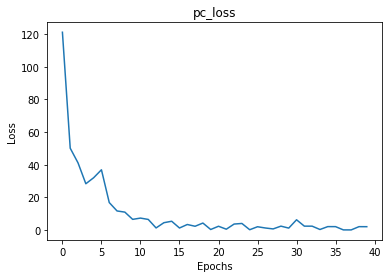

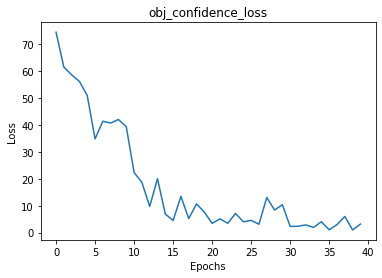

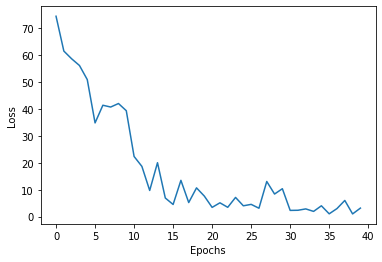

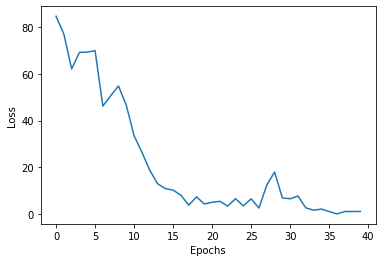

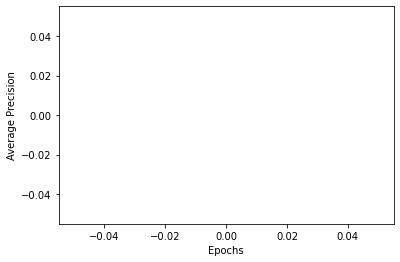

In [ ]:
path = "/content/drive/My Drive/CIS680_2019/HW2"
# set this to where the checkpoint is saved 
resume = False # set this True if you want to resume training from a checkpoint

yolo_net=YOLO()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ## initilize device to cpu or cuda
yolo_net=yolo_net.to(device)
yolo_net.train()
learning_rate = 10e-4
lambda_coord, lambda_noobj = 5, 0.5

## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0006)

if resume == True:
  checkpoint = torch.load(path)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  
num_epochs = 40 ## intialize this, atleast 20 epoch required for training
loss_ = []
localization_loss_=[]
bbox_loss_=[]
pc_loss_=[]
obj_confidence_loss_=[]
nobj_confidence_loss_=[]

ap_ =[]

for epochs in range(num_epochs):
    ## fill in your training code
    for data in train_loader:
      input, labels = data
      input = input.to(device)
      labels = labels.to(device)
      #print(input.shape)
      #print(input.dtype)
      output = yolo_net(input)
      optimizer.zero_grad()
      loss, localization_loss, bbox_loss, pc_loss, obj_confidence_loss, nobj_confidence_loss = YoloLoss(output, labels, lambda_coord, lambda_noobj)
      loss.backward()
      optimizer.step()

    if epochs%1==0 :
      YoloLoss(output, labels, lambda_coord, lambda_noobj, False)
      print("Epoch %d/%d" % (epochs+1, num_epochs))
      loss_.append(loss.item())
      localization_loss_.append(localization_loss.item()) 
      bbox_loss_.append(bbox_loss.item())
      pc_loss_.append(pc_loss.item()) 
      obj_confidence_loss_.append(obj_confidence_loss.item()) 
      nobj_confidence_loss_.append(nobj_confidence_loss.item())
      print(loss)

      #Calculating AP : Turned off because it takes a long time
      #ap_.append(AP_test(test_loader))

    path = os.path.join('','yolo_epoch'+str(epochs))
    torch.save({
              'epoch': epochs,
              'model_state_dict': yolo_net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)
      
print("Completed Training")
fig = plt.figure()
plt.plot(loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Training")
plt.savefig("Loss_Training.png")
plt.show()


fig = plt.figure()
plt.plot(localization_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Localization")
plt.savefig("Loss_Localization.png")
plt.show()


fig = plt.figure()
plt.plot(bbox_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("bbox_loss")
plt.savefig("bbox_loss.png")
plt.show()

fig = plt.figure()
plt.plot(pc_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("pc_loss")
plt.savefig("pc_loss_.png")
plt.show()

fig = plt.figure()
plt.plot(obj_confidence_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("obj_confidence_loss")
plt.savefig("obj_confidence_loss_.png")
plt.show()

fig = plt.figure()
plt.plot(obj_confidence_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("obj_confidence_loss_.png")
plt.show()

fig = plt.figure()
plt.plot(nobj_confidence_loss_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("nobj_confidence_loss_.png")
plt.show()

fig = plt.figure()
plt.plot(ap_)
plt.xlabel("Epochs")
plt.ylabel("Average Precision")
plt.savefig("average_precision.png")
plt.show()


# Test your network.
Use the test images you created in the data preprocessing step. 


In [ ]:
#Yolo Evaluation 
def yolo_evaluation(nms_out, target):
  iou_thresh = 0.5
  debug = False
  #print(nms_out.shape)
  #print(target.shape)
  object_idx  = nms_out[:,0,:,:].nonzero()
  nobject_idx = (nms_out[:,0,:,:]==0).nonzero()

  target_object    = target[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
  predicted_object = nms_out[object_idx[:,0],:,object_idx[:,1],object_idx[:,2]]
  iou = IOU(predicted_object[:, 1:5], 
            target_object[:, 1:5], object_idx, debug)
  

  confidence_scores = nms_out[object_idx[:,0],0,object_idx[:,1],object_idx[:,2]] * torch.max(nms_out[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]],dim=1)[0]
  classes = torch.max(nms_out[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]],dim=1)[1] 
  all_matches = torch.gt(iou,iou_thresh)

  trues_idx  = target[:,0,:,:].nonzero()
  target_classes    = torch.max(target[trues_idx[:,0],5:8,trues_idx[:,1],trues_idx[:,2]], dim=1)[1]

  total_classes = 3
  trues = {}
  scores = {}
  matches = {}
  for c in range(total_classes):
    trues[c]=(torch.sum(target_classes == c)).item()
    scores[c]=(confidence_scores[classes==c]).cpu().tolist()
    matches[c]=(all_matches[classes==c]).cpu().tolist()

  debug = False

  if debug:
    print(nms_out[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]].shape)
    print("confidence scores:", confidence_scores)
    print("P objectness:", nms_out[object_idx[:,0],0,object_idx[:,1],object_idx[:,2]])
    print("P class", torch.max(nms_out[object_idx[:,0],5:8,object_idx[:,1],object_idx[:,2]],dim=1)[0])
    print("classes:,", classes)
    print("No of objects", object_idx.shape)
    print("IOU shape: ",iou.shape)
    print("IOU :",iou)
    print("matches", matches)
    print("Scores: ", scores)
    print("Trues: ", trues)

  return matches, scores, trues



label   tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
nms_out tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9997, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9953, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
AVG: (0.375, 

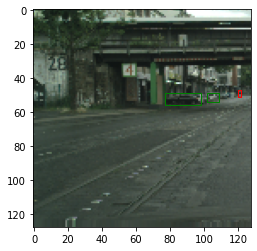

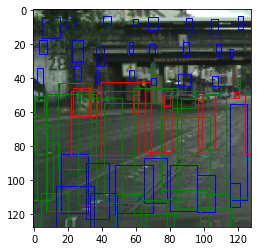

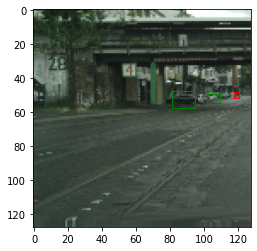

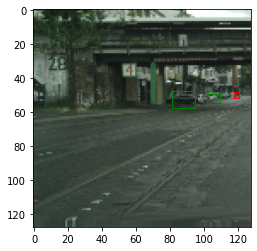

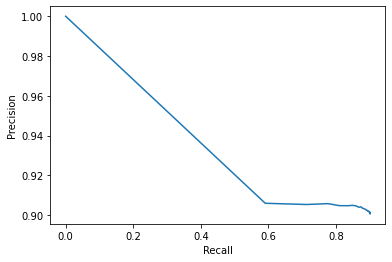

0.8434375094752242
1849
1849
2086


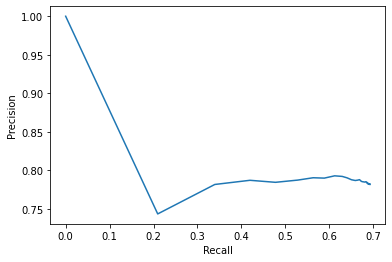

1.403070175877724
22134
22134
22085


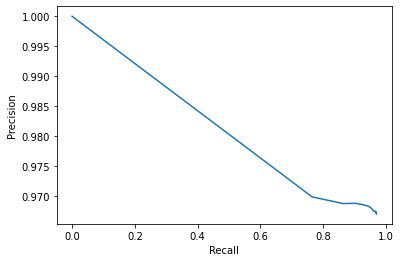

2.3544068859872196
MAP:  0.7848022953290732
AP:  2.3544068859872196
Count:  3


In [ ]:
path = "yolo_epoch39"
## intialise the path where the model has been saved 
#checkpoint = torch.load(path)
#yolo_net.load_state_dict(checkpoint['model_state_dict'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = 3
with torch.no_grad():
    test, label = TrainDataset[0]
    visualize(test, label, "ground_truth")
    test = test.unsqueeze(0)
    test = test.to(device)
    label = label.to(device)
    net_out = yolo_net(test)
  
    visualize(test[0,:,:,:].cpu(), net_out[0,:,:,:].cpu(),"without_nms")
    nms_out, nms_out1 = NMS(net_out)
    visualize(test[0,:,:,:].cpu(), nms_out1[0,:,:,:].cpu(),"basic_nms")   
    visualize(test[0,:,:,:].cpu(), nms_out[0,:,:,:].cpu(),"with_nms")
    matches, scores, trues = yolo_evaluation(nms_out, label.unsqueeze(0))
    
    print("label  ", label[0,:,:])
    print("nms_out", nms_out[0,0,:,:])

    #print(len(matches))
    #print(len(scores))
    #print(len(trues))
    print("AVG:", average_precision(matches[2],scores[2],trues[2]))
    
    AP=0
    cnt =0
    matches= {0:[],1:[],2:[]}
    scores = {0:[],1:[],2:[]}
    trues  = {0:0,1:0,2:0}
    
    for data in test_loader:

      test, label = data
      test = test.to(device)
      label = label.to(device)
      net_out = yolo_net(test)
      nms_out, nms_out1 = NMS(net_out)      
      m, s, t = yolo_evaluation(nms_out, label)
      #print(m)
      #print(s)
      #print(t)
      for c in range(classes): 
        if(len(m[c])>0):
          matches[c].extend(m[c])
        if(len(s[c])>0):
          scores[c].extend(s[c])
        trues[c]  = trues[c]+t[c]

    for c in range(classes):
      #print(matches[c].shape)
      if(len(matches[c])>0):
        print(len(matches[c]))
        print(len(scores[c]))
        print(trues[c])

        area, recall, precision = average_precision(matches[c],scores[c],trues[c])
        AP = AP + area
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.savefig("Curve"+str(c)+".png")
        plt.show()
        print(AP)
        cnt+=1;
    
    if cnt>0:
      map=AP/cnt
    
print("MAP: ",map)
print("AP: ", AP)
print("Count: ",cnt)
#print("Accuracy on %d images: %d %%" %(total, 100*correct/total))



